##### Length of individual non-null rows for each lidar_data CSV file

In [ ]:
data_folder = "../data/training"
csv_files = [] # initialize empty list for storing CSV filenames

for filename in os.listdir(data_folder): 
    if filename.endswith('.csv'):
        csv_files.append(filename)
        csv_filename = os.path.join(data_folder, filename)
        df = pd.read_csv(csv_filename)
        non_null_row_count = len(df.dropna())
        print(f"Non-null row count for '{filename}': {non_null_row_count}")

##### Approach of treating 'inf' values which were present with the use of a prior lidar sensor used in Webots (before switching to a new one)

In [ ]:
# min_sensor_range = 0 # define an appropriate minimum sensor range
X = X.replace([np.inf, -np.inf], min_sensor_range)

# or max_sensor_range = 1000 # define an appropriate maximum sensor range
X = X.replace([np.inf, -np.inf], max_sensor_range)

##### Loading compressed file (pickle - used to save space)

In [ ]:
import os # allow us to interact with the operating system
import pickle

Load a single pickle file and converting it into a DataFrame.

In [ ]:
import pickle

pickle_filename = "../data/traininglidar_data4.pkl"
with open(pickle_filename, 'rb') as pickle_file:
    unpickled_data = pickle.load(pickle_file)

In [ ]:
# create a DataFrame from unpickled data
unpickled_data = pd.DataFrame(unpickled_data)

# unpickled_df.iloc[0:11, 14:]
display(unpickled_data.head())

When the training data was saved as individual .pkl files (alongside the CSVs), load all of them located inside the 'data_folder' and combine them into a single DataFrame.

In [ ]:
data_folder = "../data/training"
unpickled_dfs = []

for filename in os.listdir(data_folder):
    if filename.endswith(".pkl"):
        pickle_filename = os.path.join(data_folder, filename)
        with open(pickle_filename, 'rb') as pkl_file:
            unpickled_data = pickle.load(pkl_file)
            df = pd.DataFrame(unpickled_data)
            unpickled_dfs.append(df)
            print(f"Length of {filename}: {len(df)}")

# concatenate all dataframes into one
unpkled_combined_df = pd.concat(unpickled_dfs, ignore_index=True)

# print the length of the final combined DataFrame
print(f"Length of the final combined DataFrame: {len(unpkled_combined_df)}")

# display the final combined DataFrame
unpkled_combined_df

##### Loading compressed file (joblib with gzip=3 compression - used to save space)

In [ ]:
import joblib

joblib_filename = "..data/training/lidar_data8.joblib1.gz"
with open(joblib_filename, 'rb') as joblib_file:
    loaded_data = joblib.load(joblib_file)

In [ ]:
# create a DataFrame from unpickled data
loaded_df = pd.DataFrame(loaded_data)

# loaded_df.iloc[0:11, 14:]
display(loaded_df.head())

During training, each file was saved as a CSV, pickle, and joblib file. The goal was to ideally to only store compressed training files to save space and load them to create a single DataFrame which would be used to train models on for testing. However, Webots had an issue with the compression of these pickle and joblib files due to errors that resulting from the file sizes being too large resulting in longer than normal compression and loading times, inevitably causing it to timeout. 
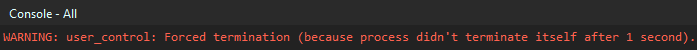

Below is an example of compression for a trained random forest classifier model (using "default" parameters) with a compression gzip=5.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import joblib

# remove rows that contain NaN values (for keyboard input, y)
unpkled_combined_df = unpkled_combined_df.dropna()

# extract features (sensor readings) and labels (control inputs)
X = unpkled_combined_df.iloc[:, 1:]  # sensor readings
y = unpkled_combined_df.iloc[:, 0]   # keyboard input

max_sensor_range = 1000  # define an appropriate maximum sensor range
X = X.replace([np.inf, -np.inf], max_sensor_range)

# display(X.iloc[0:11, 14:])

# create and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# train the model on the entire dataset
model.fit(X, y)

# save the trained model to a file using joblib
joblib.dump(model, 'trained_model.joblib', compress=('gzip', 5))

##### Used to compare the differences between the same CSV files but had different sizes (i.e. different number of kilobytes)

In [ ]:
import csv

path1 = "../data/model/lidar_data.csv"
path2 = "../data/model/lidar_data_combined.csv"

with open(path1) as f1, open(path2) as f2:
    reader1 = csv.reader(f1)
    reader2 = csv.reader(f2)

    for i, row1 in enumerate(reader1):
        try:
            row2 = next(reader2)
        except StopIteration:
            print(f"Row {i+1}, f1 has this extra row compared to f2")
            continue

        if row1 == row2:
            continue

        if len(row1) != len(row2):
            print(f"Row {i+1} of f1 has {len(row1)} cols, f2 has {len(row2)} cols")
            continue

        for j, cell1 in enumerate(row1):
            cell2 = row2[j]
            if cell1 != cell2:
                print(f'Row {i+1}, Col {j+1} of f1 is "{cell1}", f2 is "{cell2}"')

    for row2 in reader2:
        i += 1
        print(f"Row {i+1}, f2 has this extra row compared to f1")

In [ ]:
import pandas as pd

def compare_csv_files(file1, file2):
    # read the CSV files into pandas DataFrames
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    # check if the DataFrames are equal
    are_equal = df1.equals(df2)

    if are_equal:
        print("The data in the two CSV files is identical.")
    else:
        print("Differences found between the two CSV files:")
        # find and display the specific differences
        diff = df1.compare(df2)
        print(diff)

# paths to the two CSV files
path1 = "../data/model/lidar_data.csv"
path2 = "../data/model/lidar_data_combinedog.csv"

# compare the CSV files
compare_csv_files(path1, path2)

##### Generate video of lidar range (distance measurements) over simulated time

Test environment 2 - Random Forest Classifier

In [ ]:
import cv2
import seaborn as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load the CSV file for the Random Forest Classifier
csv_data = pd.read_csv("../data/testing/env1/lidar_data_rfc_model1_env1.csv")

# calculate the maximum and minimum range values
range_max = 1.1 * csv_data.iloc[:, 1:].max().max()
range_min = 0

vid_obj = cv2.VideoWriter('rfc_lidar_range.avi', cv2.VideoWriter_fourcc(*'DIVX'), 32, (640,480))
laser_idx = np.arange(128)
for k in range(0, len(csv_data), 10):
    key = csv_data['Predicted Action'].iloc[k]
    ranges = csv_data.iloc[k,1:]

    fig, ax = plt.subplots()
    ax = sb.lineplot(x=laser_idx,y=ranges)
    ax.set_title(key)
    ax.set_xlabel('Laser Index')
    ax.set_ylabel('Laser Range')
    ax.set_ylim(range_min,range_max)

    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    vid_obj.write(frame)
    plt.close()

vid_obj.release()

In [ ]:
1.1*csv_data.iloc[:,1:].max().max()